In [1]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt
import os
import random 
import scipy.misc
from skimage import io, transform
from tqdm import *
%matplotlib inline

In [2]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):

    X_train = []
    X_test = []
    TRAIN_DIR = os.path.join("optimization-ii-project-3")
    TEST_DIR = os.path.join("optimization-ii-project-3")
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c)
        if os.path.isdir(c_dir):
            c_imgs = os.listdir(c_dir)
            random.shuffle(c_imgs)
            num_images= num_images_per_class_train

            for img_name_i in c_imgs[0:num_images]:
                img_i = io.imread(os.path.join(c_dir, img_name_i))
                img_i=img_i.astype(np.float)      
#                 print(img_i.shape)          
                X_train.append(img_i)
            for img_name_i in c_imgs[num_images:num_images+2]:
                img_i = io.imread(os.path.join(c_dir, img_name_i))
                img_i=img_i.astype(np.float)      
#                 print(img_i.shape)          
                X_test.append(img_i)

    random.shuffle(X_train)
    random.shuffle(X_test)
    return np.array(X_train), np.array(X_test)
X_train_orig, X_test_orig = load_dataset_small()
print(X_train.shape)
print(X_test.shape)

NameError: name 'X_train' is not defined

In [3]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
# S: secret image
input_S = X_train[0:X_train.shape[0] //2]

# C: cover image
input_C = X_train[X_train.shape[0] //2]

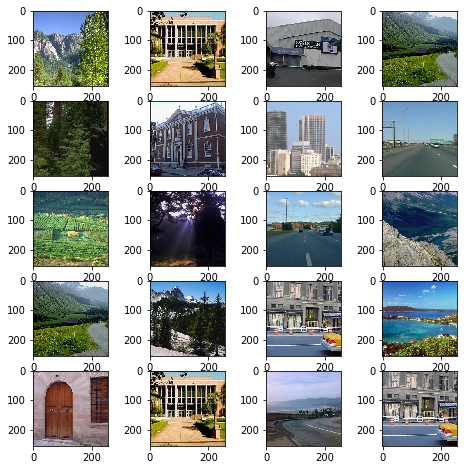

In [4]:
fig = plt.figure(figsize =(8,8))
columns =4
rows =5
for i in range(1,columns*rows +1):
    #Randomly samples from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns ,i)
    plt.imshow(X_train[img_idx])
plt.show()

In [26]:


#Loss for the full model, used for preparation and hidding networks
class full_loss(nn.Module):
    def __init__(self):
        super(full_loss,self).__init__()
        
    def forward(self,S_prime, C_prime, S, C, B):
        
        loss_cover = torch.nn.functional.mse_loss(C_prime, C)
        loss_secret = torch.nn.functional.mse_loss(S_prime, S)
        loss_all = loss_cover + B * loss_secret
        return loss_all, loss_cover, loss_secret
def gaussian(tensor, mean=0, stddev=0.1):
    '''Adds random noise to a tensor.'''
    
    noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1)
    return Variable(tensor + noise)

In [21]:
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.initialP3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialP4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialP5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalP3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalP4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalP5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())

    def forward(self, p):
        p1 = self.initialP3(p)
        p2 = self.initialP4(p)
        p3 = self.initialP5(p)
        mid = torch.cat((p1, p2, p3), 1)
        p4 = self.finalP3(mid)
        p5 = self.finalP4(mid)
        p6 = self.finalP5(mid)
        out = torch.cat((p4, p5, p6), 1)
        return out

# Hiding Network (5 conv layers)
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.initialH3 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialH4 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialH5 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalH4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalH5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))
        
    def forward(self, h):
        h1 = self.initialH3(h)
        h2 = self.initialH4(h)
        h3 = self.initialH5(h)
        mid = torch.cat((h1, h2, h3), 1)
        h4 = self.finalH3(mid)
        h5 = self.finalH4(mid)
        h6 = self.finalH5(mid)
        mid2 = torch.cat((h4, h5, h6), 1)
        out = self.finalH(mid2)
        out_noise = gaussian(out.data, 0, 0.1)
        return out, out_noise

# Reveal Network (2 conv layers)
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.initialR3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialR4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialR5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalR4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalR5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))

    def forward(self, r):
        r1 = self.initialR3(r)
        r2 = self.initialR4(r)
        r3 = self.initialR5(r)
        mid = torch.cat((r1, r2, r3), 1)
        r4 = self.finalR3(mid)
        r5 = self.finalR4(mid)
        r6 = self.finalR5(mid)
        mid2 = torch.cat((r4, r5, r6), 1)
        out = self.finalR(mid2)
        return out
class make_model(nn.Module):
    def __init__(self):
        super(make_model, self).__init__()
        self.m1 = PrepNetwork()
        self.m2 = HidingNetwork()
        self.m3 = RevealNetwork()

    def forward(self, secret, cover):
        x_1 = self.m1(secret)
        mid = torch.cat((x_1, cover), 1)
        x_2, x_2_noise = self.m2(mid)
        x_3 = self.m3(x_2_noise)
        return x_2, x_3
net = make_model()

In [22]:
for m in net.modules():
    print(m)

make_model(
  (m1): PrepNetwork(
    (initialP3): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
    )
    (initialP4): Sequential(
      (0): Conv2d(3, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
      (4): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (7): ReLU()
    )
    (initialP5): Sequential(
      (0): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2

Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
ReLU()
Sequential(
  (0): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU()
  (4): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
)
Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Sequential(
  (0): Conv2d(150, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)
Conv2d(150, 50, kernel_size

Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Sequential(
  (0): Conv2d(3, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (3): ReLU()
  (4): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
)
Conv2d(3, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
ReLU()
Sequential(
  (0): Conv2d(3, 50, kernel_size=(5, 5), stri

In [40]:
TRAIN_PATH = os.path.join("train")
batch_size = 2
num_epochs = 3
learning_rate = 0.0001
beta = 1
train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TRAIN_PATH,
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor()
        ])), batch_size=batch_size, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

In [42]:
# for i in train_loader:
#     print(i[0].shape)

In [43]:

def train_model(train_loader, beta, learning_rate):
    
    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()
        
        train_losses = []
        
        loss = full_loss()
        # Train one epoch
        for idx, train_batch in enumerate(train_loader):

            data, _  = train_batch
            
            # Saves secret images and secret covers
            train_covers = data[:len(data)//2]
            train_secrets = data[len(data)//2:]
            
            # Creates variable from secret and cover images
            train_secrets = Variable(train_secrets, requires_grad=False)
            train_covers = Variable(train_covers, requires_grad=False)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            train_hidden, train_output = net(train_secrets, train_covers)

            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = loss(train_output, train_hidden, train_secrets, train_covers, beta)
            train_loss.backward()
            optimizer.step()
            
            # Saves training loss.
            a = train_loss.data.item()
#             print(train_loss.data)
#             print(a)
            
            train_losses.append(train_loss.data.item())
            loss_history.append(train_loss.data.item())
            
            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(idx+1, len(train_loader), train_loss.data.item(), train_loss_cover.data.item(), train_loss_secret.data.item()))
    
        torch.save(net.state_dict(), MODELS_PATH+'Epoch N{}.pkl'.format(epoch+1))
        
        mean_train_loss = np.mean(train_losses)
    
        # Prints epoch average loss
        print ('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
                epoch+1, num_epochs, mean_train_loss))
    
    return net, mean_train_loss, loss_history

In [ ]:
net, mean_train_loss, loss_history = train_model(train_loader, beta, learning_rate)

c:\users\junli\appdata\local\continuum\anaconda3\envs\allennlp_source\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Training: Batch 1/40. Loss of 0.1047, cover loss of 0.0564, secret loss of 0.0483
Training: Batch 2/40. Loss of 0.1797, cover loss of 0.1227, secret loss of 0.0569
Training: Batch 3/40. Loss of 0.0942, cover loss of 0.0647, secret loss of 0.0294
Training: Batch 4/40. Loss of 0.1530, cover loss of 0.0453, secret loss of 0.1076
Training: Batch 5/40. Loss of 0.1706, cover loss of 0.0837, secret loss of 0.0869
Training: Batch 6/40. Loss of 0.2730, cover loss of 0.0595, secret loss of 0.2135
Training: Batch 7/40. Loss of 0.3048, cover loss of 0.1056, secret loss of 0.1992
Training: Batch 8/40. Loss of 0.2056, cover loss of 0.0915, secret loss of 0.1140
Training: Batch 9/40. Loss of 0.2466, cover loss of 0.0646, secret loss of 0.1819
Training: Batch 10/40. Loss of 0.1319, cover loss of 0.0599, secret loss of 0.0719
Training: Batch 11/40. Loss of 0.1060, cover loss of 0.0523, secret loss of 0.0537
Training: Batch 12/40. Loss of 0.1174, cover loss of 0.0531, secret loss of 0.0643
Training: Bat